Drag forces based on 
https://en.wikipedia.org/wiki/Bicycle_performance


Air drag
https://en.wikipedia.org/wiki/Bicycle_performance#Air_drag

$P_{D}\,=\tfrac {1}{2}\,\rho \,v^{3}\,C_{D}\,A$ in still air

- $\rho$  is the air density, which is about 1.225 kg/m^3 at sea level and 15 deg. C.[19]
- $v $ is the speed relative to the road,
- $C_{D}\,A$ is a characteristic area times its associated drag coefficient.

Cd ~ 1

e.g. 
https://en.wikipedia.org/wiki/File:CyclingPowerComponents.svg

![power components](CyclingPowerComponents.svg.png)

notes on drag coef:
https://en.wikipedia.org/wiki/Drag_coefficient
- cube-like shape ~ 1 
- sphere shape ~ 0.5
- streamlined (tear) < 0.1
that is for a Reynolds number of 10^4 meaning laminar flow apparently (transition being 5 x 10^5)
Seems like the drag coefficient cd decreases with increase Re (though the drag itself increases)
road bike ~ 1

In [44]:
import matplotlib
%matplotlib notebook

In [78]:
from pyproj import Geod

geod = Geod(ellps='clrk66')

def calcdist(a, b):
    
    if len(a) == 3:
        lo, la, z = a
        lo2, la2, z2 = b
    else:
        lo, la = a
        lo2, la2 = b
        z = z2 = 0
        
    _, _, distx = geod.inv(lo, la, lo2, la2)
    distz = z2-z
    
    return (distx**2 + distz**2)**0.5


import xml.etree.ElementTree as ET
import numpy as np


class Track:
    def __init__(self, track, z=None):
        self.track = track = np.asarray(track)
        self.lon, self.lat = lon, lat = self.track.T
        self.z = z if z is not None else np.zeros_like(lon)
        
        # pre-calc
        self.dx = dx = np.array([calcdist(track[i], track[i-1]) for i in range(1, len(track))])
        self.dz = dz = np.diff(self.z)
        self.ds = (dx**2 + dz**2)**0.5
        self.dist = np.sum(self.ds)
        self.slope = self.dz/self.ds
                
    @classmethod
    def readgpx(cls, fname):
        tree = ET.parse(fname)
        root = tree.getroot()
        trk = list(root)[1]
        trkseg = list(trk)[1]
        track = np.array([(float(p.attrib['lon']), float(p.attrib['lat'])) for p in trkseg])
        z = np.array([float(list(p)[0].text) for p in trkseg])
        return cls(track, z)
    
    @property
    def line(self):
        import shapely.geometry as shg
        return shg.LineString(self.track)
    
        
def readgpx(fname):
    return Track.readgpx(fname)

In [1054]:
# gravity
g = 9.81

# air drag coefs
rho = 1.225

class Cycle:
    def __init__(self, power, mass=85, CdA=0.5, Crr=0.005):
        'nominal values'
        self.power = human+motor*efficiency
        self.mass = mass
        self.dcoef = rho*CdA/2
        self.crr = Crr
        
    def forces(self, v, slope):
        gravity = self.mass*g*slope
        airdrag = self.dcoef*v**2
        rolling = self.mass*g*self.crr
        return gravity, airdrag, rolling
    
    def balance_velocity(self, slope, power=None):
        gravity, airdrag, rolling = self.forces(1, slope)
        coefs = np.array([airdrag, 0, gravity+rolling, -self.power if power is None else -power])
        roots = np.roots(coefs)
        realroots = [r.real for r in roots if r.imag == 0 and r.real > 0]
        assert len(realroots) == 1, str(realroots)+ ' slope: '+str(slope)
        return realroots[0]    
    
    def travelspeed(cycle, aslope, vmin=4/3.6, vmax=100):
        v = np.array([cycle.balance_velocity(s) if np.isfinite(s) else vmin for s in aslope])
        v[v < vmin] = vmin
        v[v > vmax] = vmax
        return v
    
    
class ECycle(Cycle):
    def __init__(self, human, motor, efficiency=0.8, mass=100, CdA=0.5, Crr=0.005, regen=0):
        'nominal values'
        super().__init__(human+motor*efficiency, CdA=CdA, Crr=Crr)
        self.human = human
        self.motor = motor
        self.efficiency = efficiency
        self.regen = regen
    
    def powers(cycle, aslope, speed):
        gravity, airdrag, rolling = cycle.forces(speed, aslope)
        return gravity*speed, airdrag*speed, rolling*speed

        
def Trip(cycle, track, speed=None, vmin=4/3.6, vmax=100):
    """class-like function (javascript style)
    """
    
    if speed is None:
        speed = cycle.travelspeed(track.slope, vmin=vmin, vmax=vmax) 
    else:
        speed = np.zeros_like(track.slope) + speed
        
    traveltime = np.cumsum(track.ds / speed / 3600)
    dist = np.cumsum(track.ds)*1e-3
    H = traveltime[-1]
    h = int(H)
    m = int((H-h)*60)

    dt = track.ds / speed
    Pg, Pd, Pr = cycle.powers(track.slope, speed)
    load = Pd + Pg + Pr

    cumload = np.cumsum(np.where(load > 0, load*dt/3600, 0))
    cumextra = np.cumsum(np.where(load-human < 0, (human-load)*dt/3600, 0))
    cumregen = cumextra * getattr(cycle, 'regen', 0)
    
    cumload_motor = np.cumsum(np.where(load-human > 0, (load-human)*dt/3600, 0))
    cumload_human = np.cumsum(np.where(load-human > 0, (load*0+human)*dt/3600, 0))

    usedwh = (cumload_motor-cumregen)/efficiency
    #batterywh = usedwh/battery_usable_range
    efficiencywhkm = usedwh[-1]/track.dist*1e3
    mspeed = track.dist*1e-3 / H
    
    regen = cycle.regen
    
    def __str__():
        return ('{:.0f} Wh, {:.1f} Wh/km, {:.0f} km/h, {}h {}m, {:.0f} km'.format(usedwh[-1], efficiencywhkm, mspeed, h,m, track.dist*1e-3))

    def summary():
        print(__str__())
    
    def _repr_html_():
        return __str__()
    
    def add_elev():
        ax = plt.gca()
        ax2 = ax.twinx()
        l2, = ax2.plot(dist, track.z[1:], 'k--', label='elev')
        ax.plot([], [], linestyle=l2.get_linestyle(), color=l2.get_color(), label=l2.get_label())        
        ax2.set_ylabel('height (m)', color=l2.get_color())        
        ax.legend()
        plt.sca(ax)
        
        return trip

    def add_speed():
        ax = plt.gca()
        ax2 = ax.twinx()
        l2, = ax2.plot(dist, speed*3.6, 'k:', label='speed')
        ax.plot([], [], linestyle=l2.get_linestyle(), color=l2.get_color(), label=l2.get_label())        
        ax2.set_ylabel('speed (km/h)', color=l2.get_color())   
        ax.legend()
        plt.sca(ax)
        
        return trip
    
    def add_battery():
        ax = plt.gca()
        ax2 = ax.twinx()
        l2, = ax2.plot(dist, usedwh, 'k', label='battery')
        ax.plot([], [], linestyle=l2.get_linestyle(), color=l2.get_color(), label=l2.get_label())
        ax2.set_ylabel('battery usage (wh)', color=l2.get_color())        
        ax.legend()
        plt.sca(ax)
        
        return trip
    
    def plot():
        plt.figure()
        ax = plt.gca()

        dist = np.cumsum(track.ds)*1e-3
        l, = plt.plot(dist, track.z[1:], label='elevation')
        plt.grid()
        plt.xlabel('distance (km)')
        plt.ylabel('elevation (m)', color=l.get_color())
        ax.legend()

        plt.title(__str__())
        #plt.title('required: {:.0f} Wh, time {}:{}, '.format(cumload_motor[-1]/efficiency/battery_usable_range,h,m))
        return trip        

    def plotloadcumul():
        plt.figure()
        ax = plt.gca()

        dist = np.cumsum(track.ds)*1e-3
        l, = plt.plot(dist, cumload, label='load')
        plt.plot(dist, cumload_human, label='human')
        #plt.plot(dist, cumload_motor, label='load motor 100%')
        l2, = plt.plot(dist, cumload_motor/efficiency, label='load motor {}%'.format(int(efficiency*100)), )
        plt.plot(dist, cumload_motor/0.5, label='load motor 50%', color=l2.get_color(), ls='--')
        plt.plot(dist, cumextra, label='lost w/o regen')

        plt.grid()
        plt.xlabel('distance (km)')
        plt.ylabel('required energy (Wh)', color=l.get_color())
        plt.legend()

        plt.title(__str__())
        #plt.title('required: {:.0f} Wh, time {}:{}, '.format(cumload_motor[-1]/efficiency/battery_usable_range,h,m))
        return trip
    
    def plotload():
        plt.figure()
        dist = np.cumsum(track.ds)*1e-3
        plt.plot(dist, Pg, label='gravity')
        plt.plot(dist, Pd, label='drag')
        plt.plot(dist, Pr, label='rolling')
        #plt.plot(dist, load, label='total', c='k')
        plt.grid()
        plt.xlabel('distance (km)')
        plt.ylabel('power (W)')
        plt.legend()        
        return trip
        
    # public methods
    trip.summary = summary
    trip.__str__ = __str__
    trip._repr_html_ = _repr_html_
    trip.plot = plot
    trip.plotload = plotload
    trip.plotloadcumul = plotloadcumul
    trip.add_elev = add_elev
    trip.add_speed = add_speed
    trip.add_battery = add_battery

    trip.dist = dist
    trip.dt = dt
    trip.speed = speed
    trip.load = load
    trip.usedwh = usedwh
    #trip.Pg = Pg
    #trip.Pd = Pd
    #trip.Pr = Pr
    
    return trip        

load track

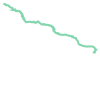

In [1041]:
#track = readgpx('capaccio-antonio-scario.gpx')
#track = readgpx('tracks/capaccio-morigerati.gpx')
#track = readgpx('tracks/capaccio-piaggine-roscigno-bellosguardo-felitto-capaccio.gpx')
#track = readgpx('tracks/capaccio-teggiano-rifugio-sotto-capaccio-road.gpx')
#track = readgpx('tracks/capaccio-teggiano-rifugio-sotto-capaccio-road.gpx')
track = readgpx('tracks/capaccio-pietrapaola.gpx')
#track = readgpx('tracks/capaccio-ageroa.gpx')
track.line

In [1055]:
cycle = ECycle(human=100, motor=250, mass=100, efficiency=0.8, CdA=0.5, regen=0)

## at constant power

1698 Wh, 6.5 Wh/km, 26 km/h, 10h 8m, 263 km


<IPython.core.display.Javascript object>


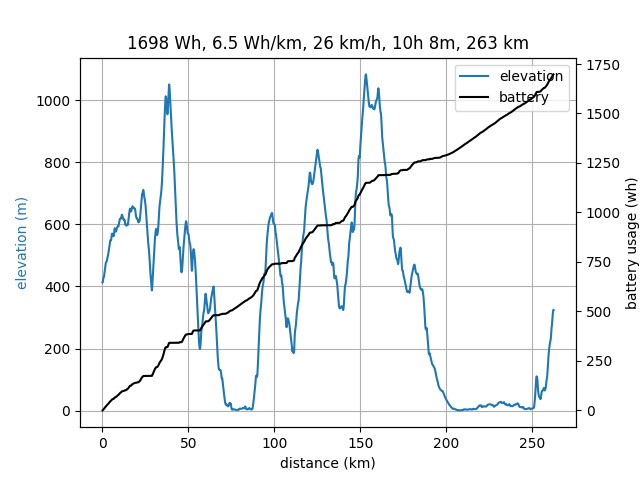

<IPython.core.display.Javascript object>


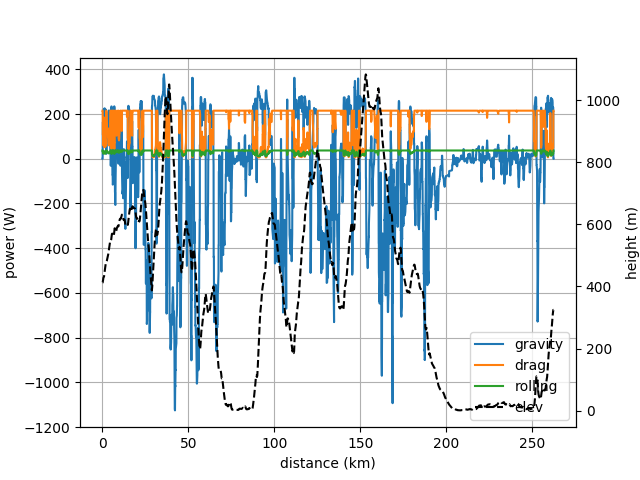

<IPython.core.display.Javascript object>


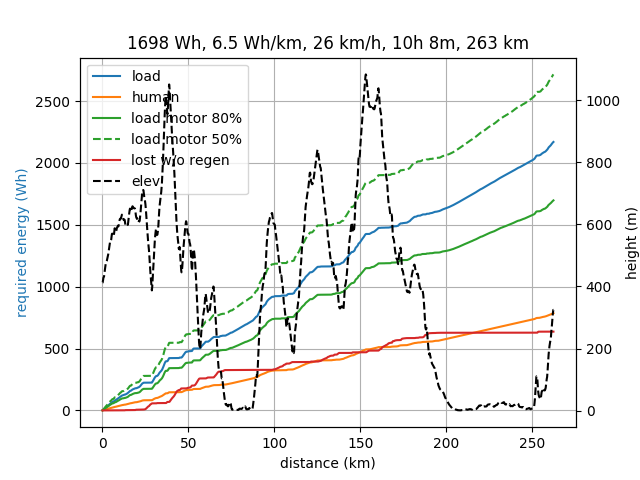

<function __main__.trip(cycle, track, speed=None, vmin=1.1111111111111112, vmax=100)>

In [1056]:
#cycle = ECycle(human=100, motor=250, mass=100, efficiency=0.8, CdA=0.7)
trip = Trip(cycle, track, vmin=10/3.6, vmax=32/3.6)
trip.summary()
trip.plot().add_battery()
trip.plotload().add_elev()
trip.plotloadcumul().add_elev()

## at constant speed

In [1032]:
trip = Trip(cycle, track, speed=25/3.6)
trip.summary()
#trip.plot().add_battery()
#add_elev()
#trip.plot().add_speed().add_elev()
#trip.plotload().add_elev()

553 Wh, 6.6 Wh/km, 25 km/h, 3h 21m, 84 km


/home/perrette/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater
/home/perrette/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in less
/home/perrette/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in greater
/home/perrette/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in greater
